# Source Code Notebook - InceptionV3


## Google Colab Configs


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Image Conversion and Validation


### Conversion of JPG to JPEG

```
pip install opencv-python
```


In [2]:
import cv2
import os
from pathlib import Path
DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Colab:
# DATA_DIR = "/content/drive/MyDrive/dataset/AI Art vs Real Art"
def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        if (dir_name != '.DS_Store'):
            files = os.path.join(data_dir,dir_name)
            for filepaths in os.listdir(files):
                file_names = os.path.join(files,filepaths)
                if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                    img = cv2.imread(str(file_names))
                    cv2.imwrite(file_names[0:-4]+".jpeg", img)
                    os.remove(file_names)

jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/AI Art")
jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/Real")

# jpg_to_jpeg(data_dir="/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art")
# jpg_to_jpeg(data_dir="/content/drive/MyDrive/dataset/AI Art vs Real Art/Real")

### Checking of the validity of Images in the dataset


In [3]:
import imghdr
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [4]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np
print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
Python Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
Tensorflow version: 2.16.1
Keras version: 3.2.1

GPU is available


### Set constants for Images


In [5]:
BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256

## By Scratch Preprocessing


### Util Methods


In [6]:
def load_dataset(path):
    all_files = [os.path.join(path, f) for f in os.listdir(path)]
    valid_files = [f for f in all_files if f.split('.')[-1].lower() in img_type_accepted_by_tf]
    return tf.data.Dataset.from_tensor_slices(valid_files)

def split_dataset(dataset, train_size, val_size):
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    return train_dataset, val_dataset

def undersample_dataset(dataset, target_size):
    return dataset.take(target_size)

def load_and_preprocess_image(file_path):
    file_extension = tf.strings.split(file_path, '.')[-1]
    image = tf.io.read_file(file_path)

    # Decode based on the file extension
    if file_extension == 'png':
        image = tf.image.decode_png(image, channels=3)
    elif file_extension == 'bmp':
        image = tf.image.decode_bmp(image, channels=3)
    elif file_extension == 'gif':
        image = tf.image.decode_gif(image)
        image = tf.squeeze(image, axis=0)  # Extract the first frame
    else:  # Default to JPEG
        image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def label_dataset(dataset, label):
    return dataset.map(lambda x: (x, label))

### Loading and Shuffling Dataset


In [7]:
AI_ART_PATH = 'dataset/AI Art vs Real Art/AI Art/AiArtData'
REAL_ART_PATH = 'dataset/AI Art vs Real Art/Real/RealArt'
# AI_ART_PATH = '/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData'
# REAL_ART_PATH = '/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt'
ai_images = load_dataset(AI_ART_PATH)
real_images = load_dataset(REAL_ART_PATH)

ai_dataset = ai_images.shuffle(buffer_size=1000, seed=1337)
real_dataset = real_images.shuffle(buffer_size=1000, seed=1337)

2024-05-19 17:05:03.596421: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-19 17:05:03.596439: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-19 17:05:03.596444: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-19 17:05:03.596465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 17:05:03.596479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Total Number of Samples per Label and Determining the Size


In [8]:
num_of_ai = len(os.listdir(AI_ART_PATH))
num_of_real = len(os.listdir(REAL_ART_PATH))
print(f'Total Number of Images: {num_of_ai + num_of_real} \nNumber of AI: {num_of_ai} \nNumber of Real: {num_of_real}')

ai_train_size = int(num_of_ai * 0.8) # 0.8 split
ai_val_size = num_of_ai - ai_train_size

real_train_size = int(num_of_real * 0.8)
real_val_size = num_of_real - real_train_size

Total Number of Images: 916 
Number of AI: 506 
Number of Real: 410


### Train and Validation Split


In [9]:
ai_train_dataset, ai_val_dataset = split_dataset(ai_dataset, ai_train_size, ai_val_size)
real_train_dataset, real_val_dataset = split_dataset(real_dataset, real_train_size, real_val_size)

target_train_size = min(ai_train_size, real_train_size)
target_val_size = min(ai_val_size, real_val_size)

print(f'Target Sizes of Training: {target_train_size} for Train, and {target_val_size} for Validation')

Target Sizes of Training: 328 for Train, and 82 for Validation


### Undersample


In [10]:
ai_train_dataset = undersample_dataset(ai_train_dataset, target_train_size)
real_train_dataset = undersample_dataset(real_train_dataset, target_train_size)

ai_val_dataset = undersample_dataset(ai_val_dataset, target_val_size)
real_val_dataset = undersample_dataset(real_val_dataset, target_val_size)

### Apply Preprocessing


In [11]:
ai_train_dataset= ai_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_train_dataset = real_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ai_val_dataset =ai_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_val_dataset = real_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### Label Datasets


In [12]:
ai_train_dataset = label_dataset(ai_train_dataset, 0)
real_train_dataset = label_dataset(real_train_dataset, 1)

ai_val_dataset = label_dataset(ai_val_dataset, 0)
real_val_dataset = label_dataset(real_val_dataset, 1)

### Combine Training Datasets and Validation Datasets


In [13]:
train_dataset = ai_train_dataset.concatenate(real_train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=1000)

val_dataset = ai_val_dataset.concatenate(real_val_dataset)
val_dataset = val_dataset.shuffle(buffer_size=1000)

print(f'Final Number of Training {train_dataset.cardinality()}')
print(f'Final Number of Validation {val_dataset.cardinality()}')

Final Number of Training 656
Final Number of Validation 163


### Batch Datasets


In [14]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

### Display Sample Images


2024-05-19 17:05:07.650511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


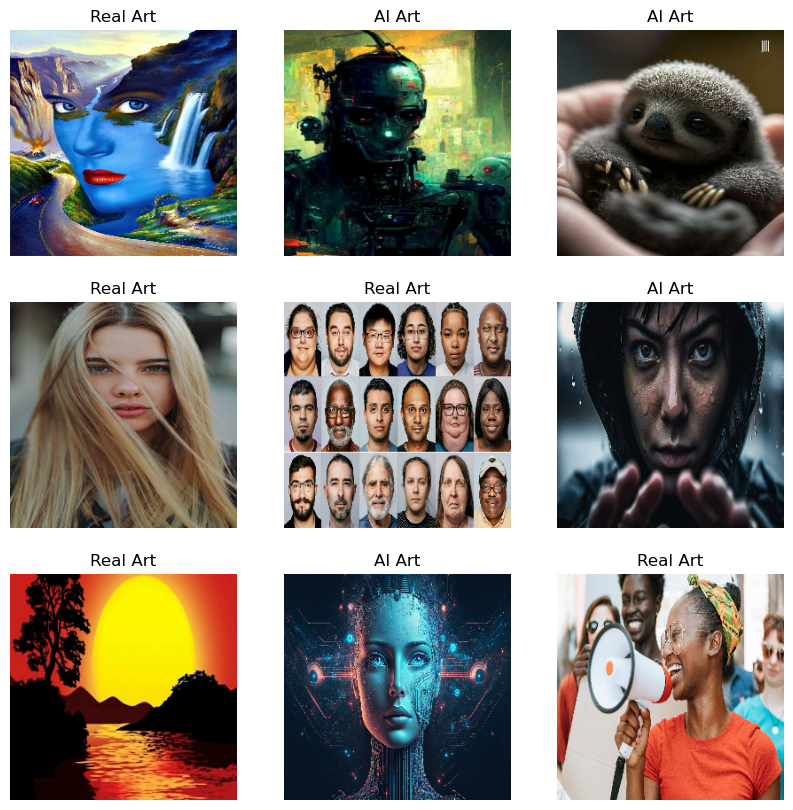

In [15]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

class_names = ['AI Art', 'Real Art']
display_binary_images(train_dataset, class_names)

### Prefetch Data for Optimization


In [16]:
from tensorflow import data as tf_data

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE).cache()
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE).cache()


## Importing InceptionV3 and Base Training


### Import InceptionV3 as our base model


In [17]:
base_model = keras.applications.InceptionV3(
    include_top=False, # Do not include the final layer, which classifies images
    weights="imagenet",
    pooling='max',
)

### Make base model non-trainable


In [18]:
for layer in base_model.layers:
    layer.trainable = False

## Adding New Layers to Base Model and Initial Training


### Util Methods


In [19]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch)
        / epochs_drop))
    return lr

In [20]:
stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

### Create new Model on Top


In [21]:
from keras import layers
# Starting layers
inputs = keras.Input(shape=(HEIGHT, WIDTH, 3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False) # run in inference mode

x = layers.Flatten()(x)
x = layers.Dense(2056, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

### Compile the Model


In [22]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(show_trainable=True)

stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
)
callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 2048)          │ 21,802,784 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 2056)          │  4,212,744 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1024)          │  2,106,368 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 28,811,049 (109.91 MB)

 Trainable params: 7,008,265 (26.73 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Train the Top Layer


In [23]:
EPOCHS = 50

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [
        keras.metrics.BinaryAccuracy(threshold=0.5),
        keras.metrics.Precision(thresholds=0.5),
        keras.metrics.Recall(thresholds=0.5)
    ],
)
print("Fitting the top layer of the model")
model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the top layer of the model
Epoch 1/50


2024-05-19 17:05:10.729623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - binary_accuracy: 0.4840 - loss: 450.9246 - precision: 0.4358 - recall: 0.4809 - val_binary_accuracy: 0.5031 - val_loss: 6.0116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 732ms/step - binary_accuracy: 0.4998 - loss: 4.5233 - precision: 0.4482 - recall: 0.4275 - val_binary_accuracy: 0.5828 - val_loss: 0.6874 - val_precision: 0.5489 - val_recall: 0.9012 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - binary_accuracy: 0.5550 - loss: 0.9671 - precision: 0.5380 - recall: 0.6122 - val_binary_accuracy: 0.6258 - val_loss: 0.6484 - val_precision: 0.6136 - val_recall: 0.6667 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 648ms/step - binary_accuracy: 0.5412 - loss: 0.8423 - precision: 0.5269 - recall: 0.6166 - val_binary_accuracy: 0.6442 - val_loss: 0.6985 - val_precision: 0.5906 - val_recall: 0.9259 - learning_rate: 0.0010
Epoch 5/50
11

## Fine Tuning the Model


### Util Methods


In [24]:
# Dynamic Learning Rate
def fine_tuned_lr_schedule(epoch):
    initial_lr = 0.00001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch)
        / epochs_drop))
    return lr

In [25]:
stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
)
callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(fine_tuned_lr_schedule),
]

### Unfreeze Layers


In [26]:
# for layer in base_model.layers:
#     if isinstance(layer, keras.layers.Conv2D):
#         layer.trainable = True

for layer in base_model.layers:
    layer.trainable = True

In [27]:
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [
        keras.metrics.BinaryAccuracy(threshold=0.5),
        keras.metrics.Precision(thresholds=0.5),
        keras.metrics.Recall(thresholds=0.5),
    ],
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 2048)          │ 21,802,784 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 2056)          │  4,212,744 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1024)          │  2,106,368 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 35,819,316 (136.64 MB)

 Trainable params: 28,776,617 (109.77 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 7,008,267 (26.73 MB)

In [28]:
print("Fitting the end-end model")
fine_tuned_model = model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the end-end model
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 205s 15s/step - binary_accuracy: 0.5085 - loss: 0.6917 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_binary_accuracy: 0.5092 - val_loss: 0.6916 - val_precision_1: 1.0000 - val_recall_1: 0.0123 - learning_rate: 1.0000e-05
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 112s 10s/step - binary_accuracy: 0.5326 - loss: 0.6782 - precision_1: 1.0000 - recall_1: 0.0483 - val_binary_accuracy: 0.4969 - val_loss: 0.6893 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - binary_accuracy: 0.6723 - loss: 0.6645 - precision_1: 1.0000 - recall_1: 0.3335 - val_binary_accuracy: 0.4908 - val_loss: 0.6895 - val_precision_1: 0.4545 - val_recall_1: 0.1235 - learning_rate: 1.0000e-05
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - binary_accuracy: 0.7732 - loss: 0.6479 - precision_1: 1.0000 - recall_1: 0.5390 - val_binary_accuracy: 0.5399 - val_loss: 0.6856

## Evaluation of the Model


### Predicting a Specific Image


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predictions: [0.5220317]
The predicted class for the image dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg is: Real Art


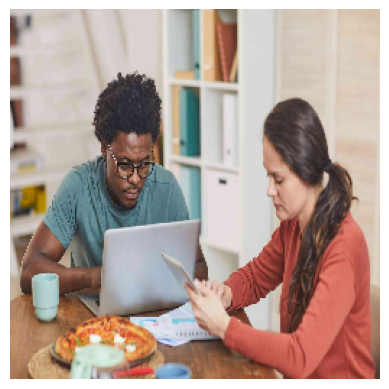

In [29]:
img_path = "dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"
# img_path = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"

img = keras.preprocessing.image.load_img(img_path,
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")


if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

result_string = f'The predicted class for the image {img_path} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Predicting a Random Image


dataset/AI Art vs Real Art/AI Art/AiArtData
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predictions: [0.31526712]
The predicted class for the image AI-Art.jpeg is: AI Art


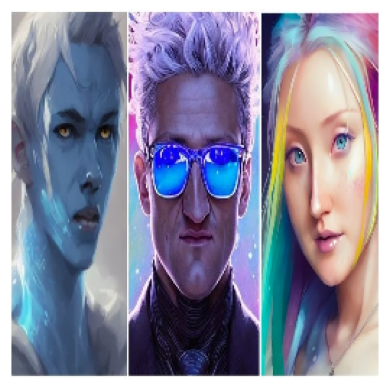

In [30]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"

# if folder_number == 1:
#     dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData"
# else:
#     dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt"
print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path,
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")


if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

result_string = f'The predicted class for the image {random_file} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in terms of Epochs


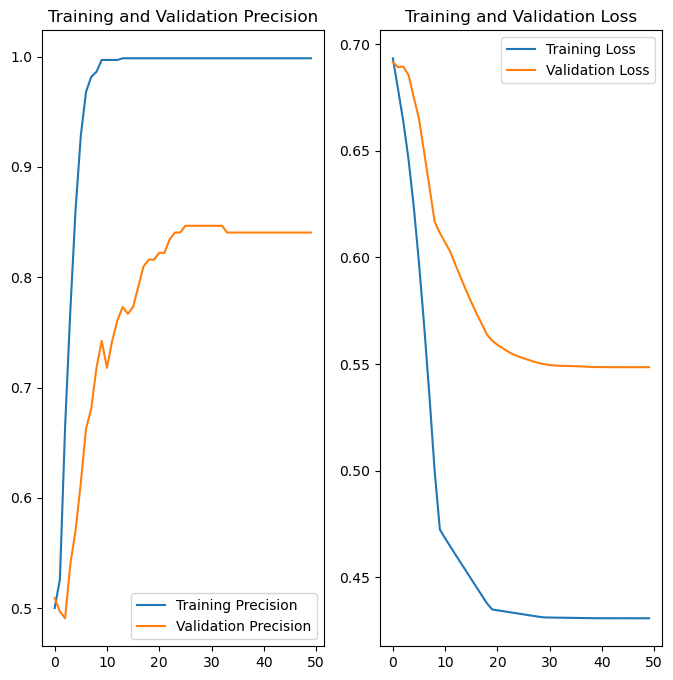

In [32]:
acc= fine_tuned_model.history['binary_accuracy']
val_acc= fine_tuned_model.history['val_binary_accuracy']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

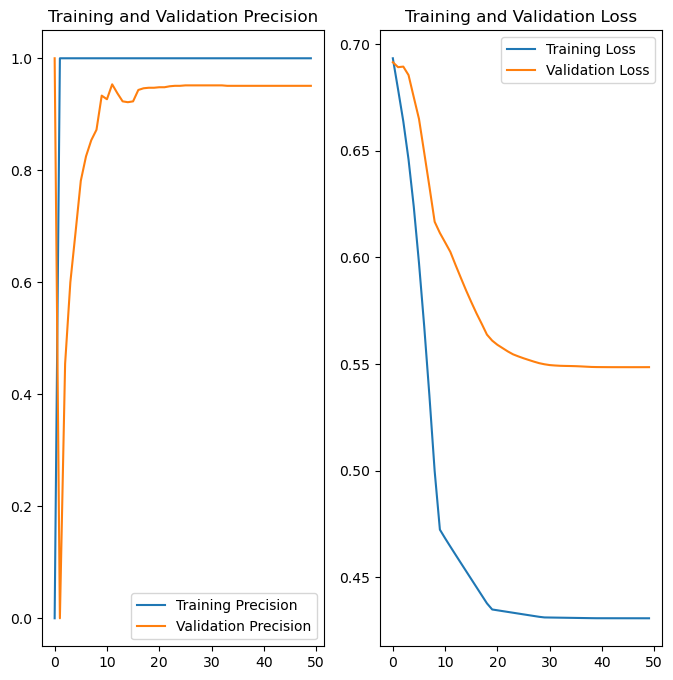

In [33]:
prec = fine_tuned_model.history['precision_1']
val_prec = fine_tuned_model.history['val_precision_1']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

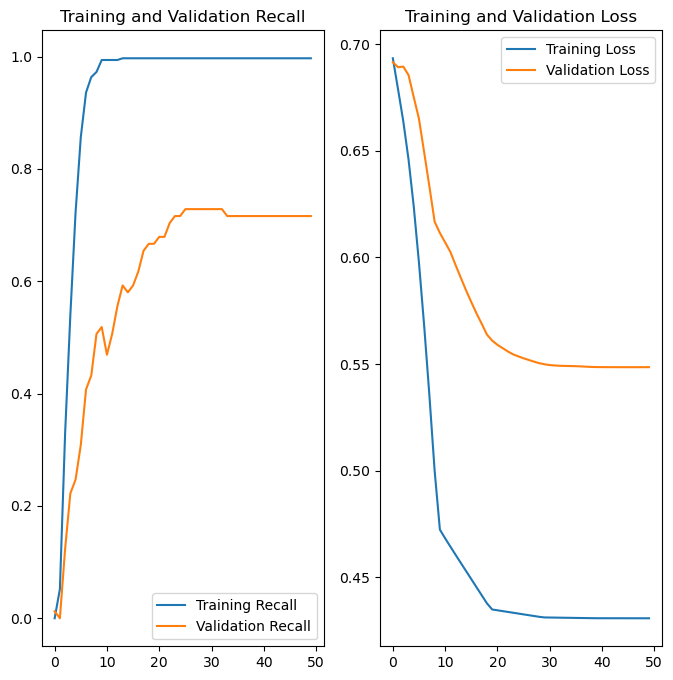

In [34]:
rec = fine_tuned_model.history['recall_1']
val_rec = fine_tuned_model.history['val_recall_1']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()